<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


In [4]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates = ['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [5]:
df.shape

(8192, 2)

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode = 'lines', name = 'close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

## Task 3: Data Preprocessing

In [13]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [19]:
from sklearn.preprocessing import StandardScaler

## normalize the data

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [22]:
def create_sequences(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [27]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)


In [30]:
print(X_train.shape)
print(X_test.shape)

(6523, 30, 1)
(1609, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [31]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


In [34]:
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
]
)

In [35]:
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [37]:
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split= 0.1,
    callbacks = [es],
    shuffle = False
)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 23s 4ms/sample - loss: 0.1625 - val_loss: 0.1610
Epoch 2/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.1114 - val_loss: 0.0986
Epoch 3/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0903 - val_loss: 0.0443
Epoch 4/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0802 - val_loss: 0.0442
Epoch 5/100
5870/5870 [==============================] - 19s 3ms/sample - loss: 0.0717 - val_loss: 0.0618
Epoch 6/100
5870/5870 [==============================] - 20s 3ms/sample - loss: 0.0774 - val_loss: 0.0326
Epoch 7/100
5870/5870 [==============================] - 17s 3ms/sample - loss: 0.0751 - val_loss: 0.0309
Epoch 8/100
5870/5870 [==============================] - 18s 3ms/sample - loss: 0.0745 - val_loss: 0.0590
Epoch 9/100
5870/5870 [==============================] - 18s 3ms/sample - loss: 0.0759 - val_loss: 0.0528

## Task 7: Plot Metrics and Evaluate the Model

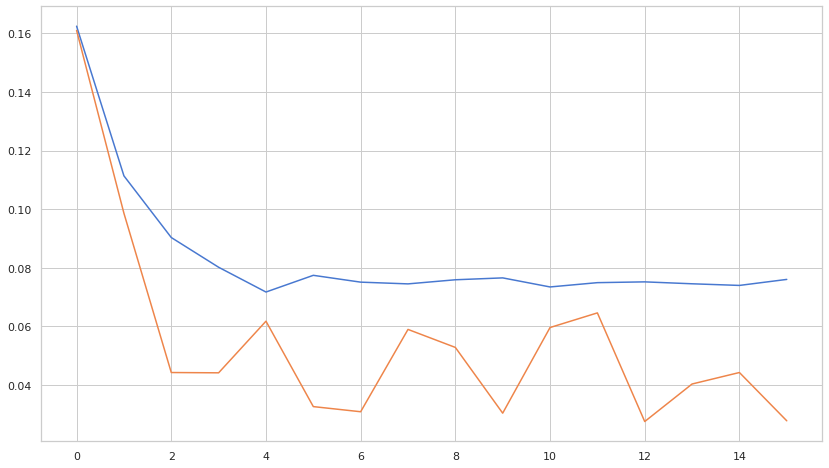

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation_loss')

In [46]:
X_train_pred = model.predict(X_train)

In [48]:
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns = ['Error'])

In [49]:
model.evaluate(X_test, y_test)

1609/1609 [==============================] - 2s 949us/sample - loss: 1995.0313


1995.0313287501456

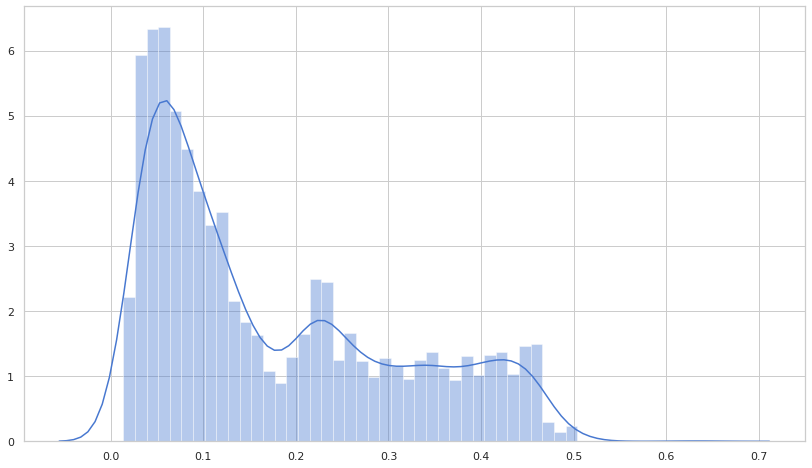

In [52]:
sns.distplot(train_mae_loss, bins=50, kde = True)

In [53]:
threshold = 0.65


In [54]:
X_test_pred = model.predict(X_test)

In [55]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test),axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [59]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [60]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1349.96,1296.937381,0.65,True
6584,2012-02-09,1351.95,1299.758623,0.65,True
6585,2012-02-10,1342.64,1302.642793,0.65,True
6586,2012-02-13,1351.77,1305.742066,0.65,True
6587,2012-02-14,1350.50,1308.701136,0.65,True


In [61]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,2717.07,2742.089210,0.65,True
8188,2018-06-26,2723.06,2741.732954,0.65,True
8189,2018-06-27,2699.63,2741.497489,0.65,True
8190,2018-06-28,2716.31,2741.102699,0.65,True
8191,2018-06-29,2718.37,2740.898262,0.65,True


In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.loss,
                         mode = 'lines', name = 'Test_Loss'
                        ))
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.threshold,
                         mode = 'lines', name = 'Test_Loss'
                        ))
fig.update_layout(showlegend = True)
fig.show()

In [70]:
anomallies = test_score_df[test_score_df.anomaly == True]
anomallies.head()


,date,close,loss,threshold,anomaly
6583,2012-02-08,1349.96,1296.937381,0.65,True
6584,2012-02-09,1351.95,1299.758623,0.65,True
6585,2012-02-10,1342.64,1302.642793,0.65,True
6586,2012-02-13,1351.77,1305.742066,0.65,True
6587,2012-02-14,1350.50,1308.701136,0.65,True


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),
                         mode = 'lines', name = 'Close_price'
                        ))
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.threshold,
                         mode = 'lines', name = 'Test_Loss'
                        ))
fig.update_layout(showlegend = True)
fig.show()